# 基于RFM和K-Means的用户分群
在本项目中，我们基于用户购买数据（Transaction Data)做用户的分群，使用的方法一次是RFM模型和K-means算法。 通过本项目的练习，你即将会学到如何使用RFM和K-means的使用，以及它们之间的区别。 在很多的精准化营销场景，我们经常通过使用RFM模型做用户分群，然后针对于每一类用户做个性化的营销方案。最经典的例子是，把用户分为金牌用户、银牌用户，普通用户等。

- ```使用的数据```：```OnlineClean.xlsx```:  原始是数据：http://archive.ics.uci.edu/ml/datasets/online+retail
本项目中使用的数据是已经经过清洗之后的，原始数据的话需要大量的清洗工作。 所以大家不用担心如何清洗，因为已经都做过了。 

In [54]:
import pandas as pd
import numpy as np
import datetime as dt

In [55]:
# 读取transaction数据, 数据有些大，读取会需要点时间，耐心等几秒...
df = pd.read_excel('OnlineClean.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


对于上面的数据稍作解释一下。
- InvoiceNo: 每一次的Transaction的unique number. 比如你去了超市，买了5件东西，那这些东西就构成一个InvoiceNo
- StockCode: 表示的是每一件商品的unique number. 
- Description: 商品的描述
- Quantity: 购买的数量
- InvoiceDate: Transaction的时间
- UnitPrice: 每一件商品的价格
- CustomerID: 用户ID
- Country: 国家

In [56]:
# 对于时间属性做个转换，只保留年月日
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [57]:
# 一般情况下，在使用RFM模型的时候，一般需要过去一年的Transaction数据。为了提取过去一年的数据，我们首先对时间做一下处理。 
print('Min date = {}, Max date = {}'.format(min(df.InvoiceDate), max(df.InvoiceDate)))

Min date = 2010-12-01, Max date = 2011-12-09


从以上的输出可以看到，时间比一年稍微多点。所以我们就把2010-12-01到 2010-12-09忽略不计，从 2010-12-10开始算到2011-12-09， 这样就刚好一年的时间。 

In [58]:
# 只考虑大于2010-12-09
df = df[df['InvoiceDate']>dt.date(2010,12,9)]
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
22523,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10,1.25,15805,United Kingdom
22524,538172,79321,CHILLI LIGHTS,8,2010-12-10,4.95,15805,United Kingdom
22525,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10,2.55,15805,United Kingdom
22526,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10,2.95,15805,United Kingdom
22527,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10,0.55,15805,United Kingdom


In [59]:
# 创建一个新的变量，叫做snapshot_date。 举个例子，我们已经有了过去一年的历史数据，然后基于历史数据要计算出R, F, M。 
# 如果历史数据是昨天为止的，那当我们计算R（recency)的时候， 就需要今天 - 历史。 这样一来，今天其实就是昨天日期+1就可以了，这个
# 我们把它叫作snapshot_date
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days=1)
snapshot_date

datetime.date(2011, 12, 10)

In [60]:
# 我们再创建一个column叫作TotalSum, 来表示购买某一种商品的总额
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
22523,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10,1.25,15805,United Kingdom,15.0
22524,538172,79321,CHILLI LIGHTS,8,2010-12-10,4.95,15805,United Kingdom,39.6
22525,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10,2.55,15805,United Kingdom,30.6
22526,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10,2.95,15805,United Kingdom,35.4
22527,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10,0.55,15805,United Kingdom,13.2


> 到目前为止数据方面的整理工作已经就绪。接下来呢，需要来计算R,F,M的值了。 为了计算R,F,M需要对每一位Customer做Aggregation操作，这部分可以通过```df.groupby```函数来实现。 Recency计算：recency = snapshot_date - 最近一次用户购买日期;  Frequency计算：统计一下过去一年用户购买了多少次，这部分可以统计```InvoiceNo```的总数就可以了。通过```count```函数实现; Monetary计算：过去一年总花费的金额可以累加```TotalSum```字段就可以，使用```sum```函数实现。

- ```问题1```: 创建一个新的dataframe叫作data_rfm, 并包含Recency, Frequency, Monetary字段

In [61]:
# TODO: 写一段Aggregation函数来创建一个新的dataframe，部分代码已经给出
data_rfm = df.groupby(['CustomerID']).agg({
    'InvoiceDate': # your code,
    'InvoiceNo': # your code,
    'TotalSum': # your code
}).sort_index(ascending=True)

# 重新命名一下Columns
data_rfm.rename(columns = {'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalSum': 'MonetaryValue'}, inplace=True)

data_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,3,151,3598.21
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


到目前为止，Recency, Frequency, MonetaryValue都是数值型的。 为了用户分群，我们需要把R,F,M的值分别需要映射到bucket中，比如Recency的值映射到1，2，3，4中的某一个数值上； Frequency映射到1，2，3，4中的某一个数值上，MonetaryValue也做同样的处理。 这里需要注意的一点是：值越大就说明用户越有价值，比如R=4的用户要比R=1的用户的价值更大。 所以当我们尝试映射的时候，也需要注意这一点。 因为Recency越大说明好久没有买了，所以这时候映射之后的数要越小； 相反，对于Frequency字段，这个值越大就说明用户购买次数越多，映射之后的值也需要越大； 所以我们需要考虑这一点。 

具体映射时候需要用到的技术在课程里面也讲过，使用quantitle就可以了。 把一组数据通过quantitle分成25%， 50%， 75%点， 这样就可以分成4块了，然后每一块分别赋值，1，2，3，4就可以了。 取quantitle的时候可以直接使用 ```pd.qcut```函数。

> ```问题2：``` 针对于Recency, Frequency, MonetaryValue，把每一个值通过quantitle映射到1，2，3，4不同的bucket里面, 把新的column命名为Recency_Q, Frequency_Q, MonetaryValue_Q

In [62]:
# TODO: 创建三个新的Column, 分别表示R,F,M的quntitle值
Rquartiles = # your code
data_rfm = data_rfm.assign(Recency_Q = Rquartiles.values)

Fquartiles = # your code
data_rfm = data_rfm.assign(Frequency_Q = Fquartiles.values)

Mquartiles =  # your code
data_rfm = data_rfm.assign(Moneytary_Q = Mquartiles.values)

data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q
CustomerID,,,,,,
12346,326,1,77183.60,1,1,4
12347,3,151,3598.21,4,4,4
12348,76,31,1797.24,2,2,4
12349,19,73,1757.55,3,3,4
12350,311,17,334.40,1,1,2


In [63]:
# 创建一个新的column叫作segment， 比如Recency_Q = 1, Frequency_Q = 2, Monetary_Q=4, 则segment为124.
# 实现过程就是直接把每一个值拼接在一起。
data_rfm['Segment'] = data_rfm[['Recency_Q','Frequency_Q','Moneytary_Q']].apply(lambda x: ''.join(x.map(str)), axis=1)
data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment
CustomerID,,,,,,,
12346,326,1,77183.60,1,1,4,114
12347,3,151,3598.21,4,4,4,444
12348,76,31,1797.24,2,2,4,224
12349,19,73,1757.55,3,3,4,334
12350,311,17,334.40,1,1,2,112


> 接下来计算一下RFM_Score。这个值越大说明，说明这个用户价值越大。对于Score可以有不同的计算方式。但在这里我们使用最简单而且最经典的计算方法，其实就是把所有的值加在一起。 比如一个客户的 R=1, F=2, M=3, 则这个客户的RFM_Score为6。

- ```问题3```： 创建一个新的column叫作RFM_Score,  它的值为R,F,M之和。 

In [64]:
# TODO  创建一个新的column叫作RFM_Score
data_rfm['RFM_Score'] = # your code

data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment,RFM_Score
CustomerID,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6.0
12347,3,151,3598.21,4,4,4,444,12.0
12348,76,31,1797.24,2,2,4,224,8.0
12349,19,73,1757.55,3,3,4,334,10.0
12350,311,17,334.40,1,1,2,112,4.0


有了RFM_Score之后，就可以对用户分群了。 这个值越大，我们可以认为这个用户价值越高。 现在我们希望把用户分层三大类， 金牌客户，银牌客户，以及普通客户，那如何做分群呢？ 一种简单的方法是定义阈值的方式做。比如RFM_Score在某一个区间就认为是金牌客户，银牌客户等等。 在这里，我们就使用这种方法，规则为：

- Gold: RFM_Score >= 9 的时候
- Silver: RFM_Score >= 5 and RFM_Score < 9 的时候
- Normal: RFM_Score < 5

> ```问题4：``` 请创建一个新的Column叫作RFM_Cluster, 然后把每一位客户标记成Gold, Silver, Normal.

In [65]:
# TODO: 创建一个新的column叫作 RFM_Cluster，把每一位客户标记成Gold, Silver, Normal

# your code here...


data_rfm.head()

,Recency,Frequency,MonetaryValue,Recency_Q,Frequency_Q,Moneytary_Q,Segment,RFM_Score,RFM_Cluster
CustomerID,,,,,,,,,
12346,326,1,77183.60,1,1,4,114,6.0,Silver
12347,3,151,3598.21,4,4,4,444,12.0,Gold
12348,76,31,1797.24,2,2,4,224,8.0,Silver
12349,19,73,1757.55,3,3,4,334,10.0,Gold
12350,311,17,334.40,1,1,2,112,4.0,Normal


In [66]:
# 按照Gold, Silver, Normal来做分群，然后对于每一个群体，统计一下它们的平均Recency, 平均Frequency， 以及平局MoneytaryValue
df_rfm_custom_segment = data_rfm.groupby('RFM_Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).round(1)

df_rfm_custom_segment

,Recency,Frequency,MonetaryValue
RFM_Cluster,,,
Gold,25.9,188.7,4334.3
Normal,205.5,11.0,197.9
Silver,95.4,35.3,722.4


> ```问题5:``` 你觉得上述通过阈值的方式来分群的操作有什么缺点？ 

// 你的回答....



### 基于K-means算法的分群
接下来我们通过使用k-means算法来对用户分群，使用的值仍然是Recency, Frequency, Moneytary Value.
当我们使用k-means算法的时候经常需要做预处理工作，因为算法依赖于距离的计算，而且R,F,M的值的范围差别很大。 

对于预处理，我们做如下2个方面的工作：
1. 即使针对于某一个属性，它的值差别很大，所以我们先使用log transform把值做个转换
2. 使用归一化操作把值映射到 N(0,1)，使用的是```sklearn```里的 ```StandardScaler```。

In [69]:
# 只选取R,F,M的值
data_rfm = data_rfm[['Recency','Frequency', 'MonetaryValue']]

# 1. 先做log transform, +1是为了避免log(0)
data_rfm = np.log(data_rfm+1)

# 2. 归一化操作
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data_rfm)
data_rfm = scaler.transform(data_rfm)

In [70]:
data_rfm[0:5]

array([[ 1.52664777, -2.44463928,  3.73013332],
       [-1.8885106 ,  1.04571909,  1.28281977],
       [ 0.40511682, -0.21006894,  0.72884376],
       [-0.64034927,  0.46558321,  0.71102567],
       [ 1.4902314 , -0.67378419, -0.61176813]])

接下来试着使用K-Means算法对R,F,M的值做聚类。 首先，需要选出最合适的K值，这里使用的方法是对于每一个K值计算Distortion score，并把这个值按照K值来可视化，之后根据可视化的结果来选择合适的K值。完整的代码已经给出，只需要运行就可以看到可视化结果。  

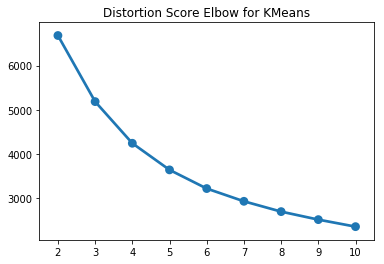

In [73]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=99).fit(data_rfm)
    cluster_labels = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.title('Distortion Score Elbow for KMeans')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

```问题6```: 基于以上的这幅图，我们通过Elbow Method来选出3个你认为最好的K值。

// 你的答案....


```问题7```: 对于每一个K值，训练K-means算法，按照K-means的结果把用户分群，最后展示每一个群体的R, F, M的平均值。 请参考第五题上面的表格。 

In [ ]:
# 第一个K值
# TODO:

In [ ]:
# 第二个K值
# TODO:

In [ ]:
# 第三个K值
# TODO: